## Work
請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333) 
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
# Hint 1 : 在 Dense 層中增加 Regularizers
# Hint 2 : 增加 Dropout 層並設定 dropout ratio 
# Hint 3 : 增加 Batch-normalization 層
from keras.layers import Dropout
from keras.layers import BatchNormalization, Activation
from keras.regularizers import l1, l2, l1_l2
def build_mlp(input_shape, regularizer, reg_ratio, output_units=10, num_neurons=[512, 256], drop_ratio=0.3):
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=regularizer(reg_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=regularizer(reg_ratio))(x)
        x = Dropout(drop_ratio)(x)
        x = BatchNormalization()(x)
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
## 超參數設定
"""
Set your hyper-parameters
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [128, 256]
MOMENTUM = 0.95
Dropout_EXP = 0.3
ratio = 1e-4
regularizers = [l1, l1_l2]

In [8]:
results = {}
for batch_size in BATCH_SIZE:
    for reg in regularizers:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Regulizer %s = %.6f" % (reg.__name__,ratio))
        model = build_mlp(input_shape=x_train.shape[1:], regularizer=reg, reg_ratio=ratio,drop_ratio=Dropout_EXP)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=batch_size, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = "exp-%s-batch:%s" % (reg.__name__,str(batch_size))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Experiment with Regulizer l1 = 0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 

50000/50000 [==============================] - 7s 142us/step - loss: 1.9875 - acc: 0.4244 - val_loss: 2.0563 - val_acc: 0.4089
Epoch 50/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.9629 - acc: 0.4262 - val_loss: 1.9660 - val_acc: 0.4290
Experiment with Regulizer l1_l2 = 0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (N

50000/50000 [==============================] - 8s 157us/step - loss: 1.8116 - acc: 0.3732 - val_loss: 1.8301 - val_acc: 0.3764
Epoch 48/50
50000/50000 [==============================] - 8s 156us/step - loss: 1.8432 - acc: 0.3556 - val_loss: 1.8799 - val_acc: 0.3619
Epoch 49/50
50000/50000 [==============================] - 8s 156us/step - loss: 1.8365 - acc: 0.3615 - val_loss: 1.8288 - val_acc: 0.3853
Epoch 50/50
50000/50000 [==============================] - 8s 156us/step - loss: 1.8262 - acc: 0.3649 - val_loss: 1.8553 - val_acc: 0.3353
Experiment with Regulizer l1 = 0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout) 

50000/50000 [==============================] - 5s 94us/step - loss: 2.9558 - acc: 0.4856 - val_loss: 2.9894 - val_acc: 0.4662
Epoch 46/50
50000/50000 [==============================] - 5s 94us/step - loss: 2.9170 - acc: 0.4837 - val_loss: 2.9237 - val_acc: 0.4822
Epoch 47/50
50000/50000 [==============================] - 5s 95us/step - loss: 2.8849 - acc: 0.4829 - val_loss: 2.8953 - val_acc: 0.4721
Epoch 48/50
50000/50000 [==============================] - 5s 94us/step - loss: 2.8489 - acc: 0.4833 - val_loss: 2.8246 - val_acc: 0.4878
Epoch 49/50
50000/50000 [==============================] - 5s 94us/step - loss: 2.8095 - acc: 0.4865 - val_loss: 2.8165 - val_acc: 0.4720
Epoch 50/50
50000/50000 [==============================] - 5s 95us/step - loss: 2.7824 - acc: 0.4833 - val_loss: 2.7775 - val_acc: 0.4805
Experiment with Regulizer l1_l2 = 0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (

50000/50000 [==============================] - 5s 102us/step - loss: 1.7299 - acc: 0.4234 - val_loss: 1.7214 - val_acc: 0.4255
Epoch 44/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.7261 - acc: 0.4217 - val_loss: 1.8121 - val_acc: 0.3836
Epoch 45/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.7562 - acc: 0.4080 - val_loss: 1.6912 - val_acc: 0.4403
Epoch 46/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.7421 - acc: 0.4147 - val_loss: 1.6618 - val_acc: 0.4422
Epoch 47/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.7304 - acc: 0.4205 - val_loss: 1.7325 - val_acc: 0.4208
Epoch 48/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.7320 - acc: 0.4180 - val_loss: 1.6830 - val_acc: 0.4382
Epoch 49/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.7237 - acc: 0.4169 - val_loss: 1.6817 - val_acc: 0.4319
Epoch 50/50
50000/50000 [==============

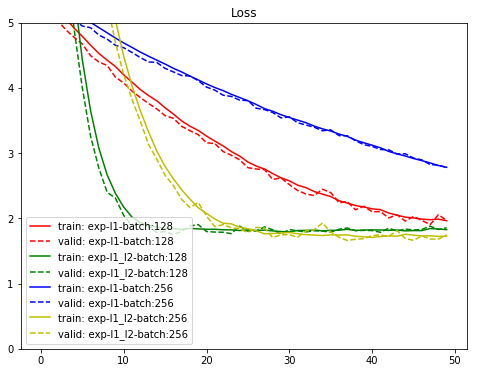

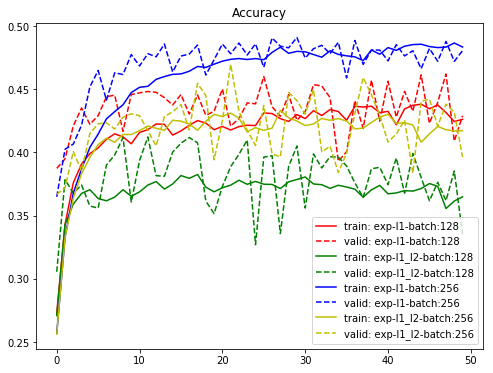

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=f"train: {cond}", color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=f"valid: {cond}", color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=f"train: {cond}", color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=f"valid: {cond}", color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()